# Digital Signals & Image Management - Project

Yuliia Tsymbal - 894213

Sara Campolattano - 906453

Induni Sandapiumi Nawarathna Pitiyage - 906451



## Retrieval Task - Face Detection & Retrieval

## Dataset Details
The dataset, found on Kaggle, consists of a collection of JPG pictures of famous people collected on the internet. Each picture is centered on a single face, and every image is encoded in RGB. The original images are of the size 250 x 250.
The dataset contains 1680 directories, each representing a celebrity.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Importing and loading the dataset directly from Kaggle


In [ ]:
# Uploading Kaggle API key (kaggle.json)
from google.colab import files
uploaded = files.upload()

#kaggle folder
!mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# Downloading the dataset in My Drive
! kaggle datasets download -d "stoicstatic/face-recognition-dataset" -p /content/drive/MyDrive

Saving kaggle.json to kaggle.json
 94% 171M/181M [00:02<00:00, 90.1MB/s]
100% 181M/181M [00:02<00:00, 86.7MB/s]


In [ ]:
# Unzipping the file
import zipfile
import os

zip_file_name = 'face-recognition-dataset.zip'

# Destination folder
extract_folder = '/content/drive/MyDrive/'

with zipfile.ZipFile(os.path.join(extract_folder, zip_file_name), 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
# List of the contents of the unzipped folder
unzipped_folder = '/content/drive/MyDrive/Face Data'
folder_contents = os.listdir(unzipped_folder)
print(folder_contents)

['Face Dataset']


In [ ]:
# Path to the main subfolder
main_subfolder = '/content/drive/MyDrive/Face Data/Face Dataset'

# List of subfolders within the main subfolder
subfolders = [f.path for f in os.scandir(main_subfolder) if f.is_dir()]

# Exploring the contents of each subfolder
for subfolder in subfolders:
    print(f"\nContents of {subfolder}:")
    contents = os.listdir(subfolder)
    print(contents)

In [ ]:
# Installing deepface

!pip install deepface

In [ ]:
from deepface import DeepFace

24-02-11 12:56:26 - Directory /root/.deepface created
24-02-11 12:56:26 - Directory /root/.deepface/weights created


In [ ]:
# Importing libraries
import keras
import numpy as np
import pandas as pd
import cv2
import random
import PIL
from PIL import Image
from os import listdir
from matplotlib import image
from matplotlib import pyplot as plt
import seaborn as sns
from time import time
import joblib

from sklearn.neighbors import KDTree, BallTree

import tensorflow
import keras
from keras.preprocessing import image as kimage
from keras.models import Sequential , Model
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import load_img,img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D , Input, ReLU, Softmax
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input

import mtcnn
from mtcnn.mtcnn import MTCNN

## 1. Face Detection

In [ ]:
detector = MTCNN()

For face detection, we decided to implement the code using the Haar Cascade face classifier.
When the face is detected, the algorithm draws a blue rectangle around the face. The images are then cut so that only the face detected is shown.

In [ ]:
def facedetector(image_path, output_path):
    # Loading the image
    img = cv2.imread(image_path)

    # Converting the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Loading the pre-trained Haar Cascade face classifier
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Performing face detection
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    # Drawing rectangles around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Cutting the image to include only the face region
        face_roi = img[y:y+h, x:x+w]

        # Saving the face region
        cv2.imwrite(output_path, face_roi)

    # Returning the number of faces detected
    return len(faces)


We define a function that processes the input images and stores them in an output folder.

In [ ]:
# Recursively processing all images
def process_images(input_folder, output_folder):
    for root, dirs, files in os.walk(input_folder):
        for filename in files:
            if filename.endswith(('.jpg')):
                input_path = os.path.join(root, filename)
                relative_path = os.path.relpath(input_path, input_folder)
                output_path = os.path.join(output_folder, relative_path)

                # Creating output folder if it doesn't exist
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                _ = facedetector(input_path, output_path)

In [ ]:
input_folder = '/content/drive/MyDrive/Face Data/Face Dataset'
output_folder = '/content/drive/MyDrive/output_folder'

process_images(input_folder, output_folder)

## 2. Data Loader & Feature Extraction
Here, we define a function that loads data from the folder containing detected faces and extracts their repsective features.
The initial number of images is equal to 8204. Hoever, we decided to exclude some of the images, that will not be fed to the model for training, in order to use them as input for the search trees and actually see if the model performs well.


In [ ]:
# Feature dummy
def identity(image):
    return image

def load_data(base_path='/content/drive/MyDrive/output_folder', feature_extractor=identity):
    # Creating folder for output features
    output_feature_folder = '/content/drive/MyDrive/output_folder_features'
    if not os.path.exists(output_feature_folder):
        os.makedirs(output_feature_folder)

    paths = []
    features = []
    count = 0

    for root, dirs, files in os.walk(base_path):
        # Skip certain folders
        if os.path.basename(root) in ['1000', '1005', '1003', '1027', '1033', '1097']:
            continue  # Skip this folder and move to the next one

        for f in sorted(files):
            # Setting a counter to monitor the process
            if count % 500 == 0:
                print(count)

            if f.endswith('.jpg'):
                # Saving path
                cur_path = os.path.join(root, f)
                paths.append(cur_path)

                # Loading file and extracting features
                image = kimage.load_img(cur_path, target_size=(224, 224))
                cur_features = feature_extractor(image)
                features.append(cur_features)

                # Saving the features to a new file
                save_path = os.path.join(output_feature_folder, f.replace('.jpg', '_features.npy'))
                np.save(save_path, cur_features)

            count += 1

    features = np.array(features)
    return features, paths

We can see that the final number of images used for training is 7638.

In [ ]:
features, paths = load_data()
print("Loaded features shape:", features.shape)
print("Number of images loaded:", len(paths))

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
Loaded features shape: (7638,)
Number of images loaded: 7638


## 3. VGG16 Model

For face retrieval, we decided to use a pre-trained convolutional neural network (CNN) model, the VGG16 model, with weights trained on the ImageNet dataset.

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input
import keras.preprocessing.image as kimage

# Defining a feature extractor and choosing VGG16 as the pretrained model
def neural_features(image):
    model = VGG16(weights='imagenet', include_top=False, pooling='avg')
    img_array = kimage.img_to_array(image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()

# Loading data with the feature extractor
t0 = time()
features, paths = load_data(feature_extractor = neural_features)

print("Feature extraction in %0.3f seconds" % (time() - t0))

Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 119ms/step
3000
1/1 [==============================] - 0s 209ms/step
3500
1/1 [==============================] - 0s 125ms/step
4000
1/1 [==============================] - 0s 122ms/step
4500
1/1 [==============================] - 0s 123ms/step
5000
1/1 [==============================] - 0s 132ms/step
5500
1/1 [==============================] - 0s 121ms/step
6000
1/1 [==============================] - 0s 126ms/step
6500
1/1 [==============================] - 0s 121ms/step
7000
1/1 [==============================] - 0s 131ms/step
7500
1/1 [==============================] - 0s 148ms/step
Feature extraction in 4102.372 seconds


We can see that the model took more than 60 minutes to extract the features.

In [ ]:
def save_features_to_drive(features, features_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(features_folder, exist_ok=True)

    # Iterate over the features and save each one
    for i, feature in enumerate(features):
        filename = f'feature_{i}.npy'  # Generating a filename
        save_path = os.path.join(features_folder, filename)
        np.save(save_path, feature)

# Specify the output folder in your Google Drive
features_folder = '/content/drive/MyDrive/features'

# Call the function to save features to the specified folder
save_features_to_drive(features, features_folder)

In [ ]:
# Creating a DataFrame for easy inspection and saving
df = pd.DataFrame({'path': paths, 'feature': list(features)})
df.to_csv('processed_data.csv', index=False)

In [ ]:
# Checking the number of features
len(features)

7638

## 4. Search Trees using KDtree and BallTree
For the search trees, we decided to use both the K-Dimensional Tree and the BallTree, and see if there is any difference in the computation of the distance and the images themselves.

The images we chose to do retrieval on are six and chosen randomly.

In [ ]:
# KDtree
kd_tree = KDTree(features)

In [ ]:
# BallTree
ball_tree = BallTree(features)

In [ ]:
# Saving the search trees
joblib.dump(kd_tree, 'KDtree.joblib')
joblib.dump(ball_tree, 'BallTree.joblib')

['BallTree.joblib']

In [ ]:
# Loading the search trees
kd_tree = joblib.load('KDtree.joblib')
ball_tree = joblib.load('BallTree.joblib')

## Querying the search trees

The input for the search trees is constituted of face-detected images (point 2.), but that were not included in the processing of the model.

In [ ]:
# Loading already face-detected images for the queries
image1 = kimage.load_img('/content/drive/MyDrive/output_folder/1000/1.jpg', target_size=(224, 224))
image2 = kimage.load_img('/content/drive/MyDrive/output_folder/1005/0.jpg', target_size=(224, 224))
image3 = kimage.load_img('/content/drive/MyDrive/output_folder/1003/1.jpg', target_size=(224, 224))
image4 = kimage.load_img('/content/drive/MyDrive/output_folder/1027/1.jpg', target_size=(224, 224))
image5 = kimage.load_img('/content/drive/MyDrive/output_folder/1033/0.jpg', target_size=(224, 224))
image6 = kimage.load_img('/content/drive/MyDrive/output_folder/1097/1.jpg', target_size=(224, 224))

In [ ]:
#  Features
image1_features = neural_features(image1)
image2_features = neural_features(image2)
image3_features = neural_features(image3)
image4_features = neural_features(image4)
image5_features = neural_features(image5)
image6_features = neural_features(image6)

image1_features.shape
image2_features.shape
image3_features.shape
image4_features.shape
image5_features.shape
image6_features.shape

1/1 [==============================] - 0s 128ms/step


(512,)

Here, we add a dimension to ensure that each feature vector is represented as a row in the 2D array, as required by the KDTree or BallTree data structure. This way, the trees can efficiently organize and search for nearest neighbors based on the feature vectors.

In [ ]:
# Adding dimension for KDtree
image1_features = np.expand_dims(image1_features, axis=0)
image1_features.shape

image2_features = np.expand_dims(image2_features, axis=0)
image2_features.shape

image3_features = np.expand_dims(image3_features, axis=0)
image3_features.shape

image4_features = np.expand_dims(image4_features, axis=0)
image4_features.shape

image5_features = np.expand_dims(image5_features, axis=0)
image5_features.shape

image6_features = np.expand_dims(image6_features, axis=0)
image6_features.shape

(1, 512)

## 5. Retrieval
We load the images for which we want to perform retrieval applying the KDtree and BallTree algorithms to see whether they output the most similar images to the ones loaded.

### Image 1
We load the image for which we want to perform retrieval

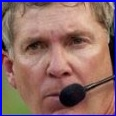

In [ ]:
from IPython.display import Image

# Path to the image
image_path = '/content/drive/MyDrive/output_folder/1000/1.jpg'

# Display the image
Image(filename=image_path)


## Applying KDtree to Image 1

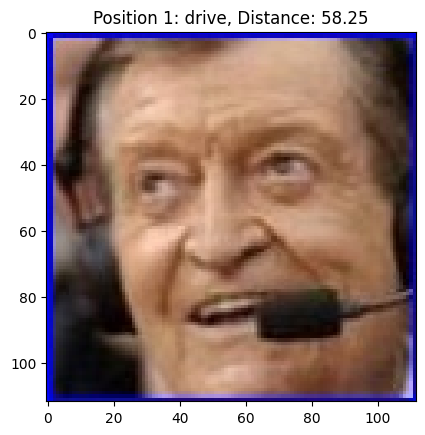

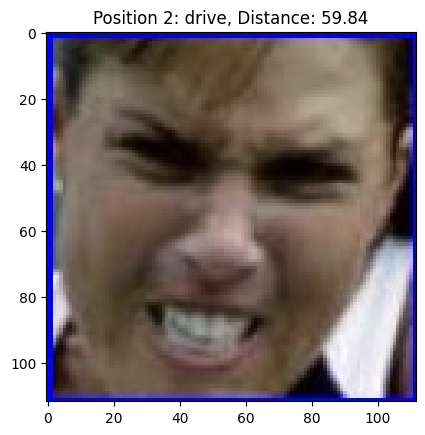

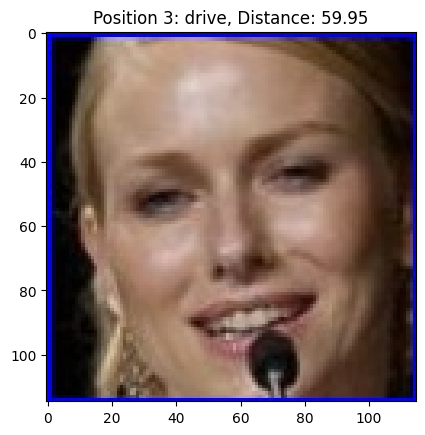

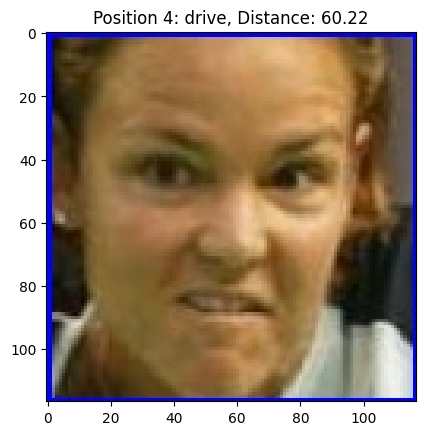

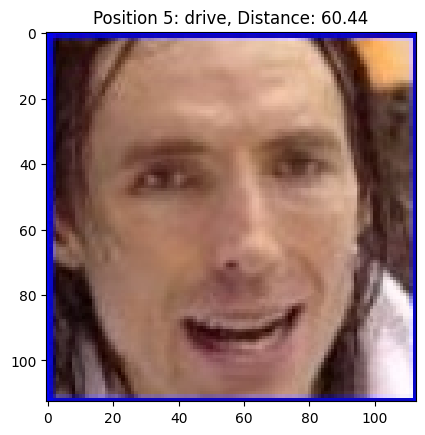

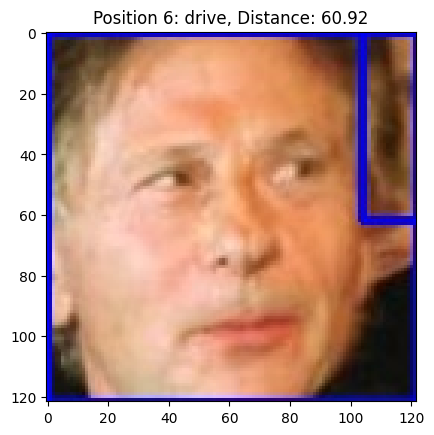

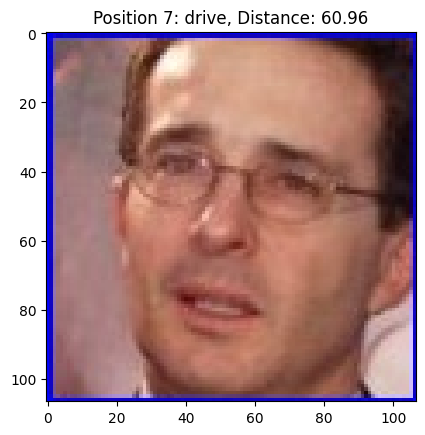

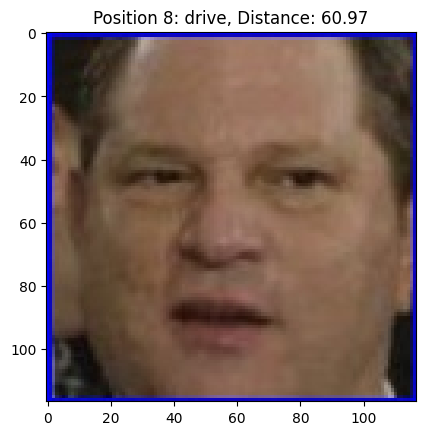

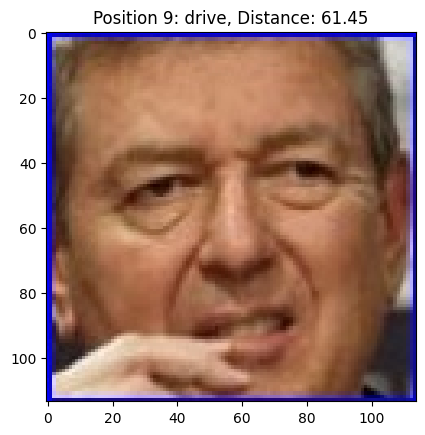

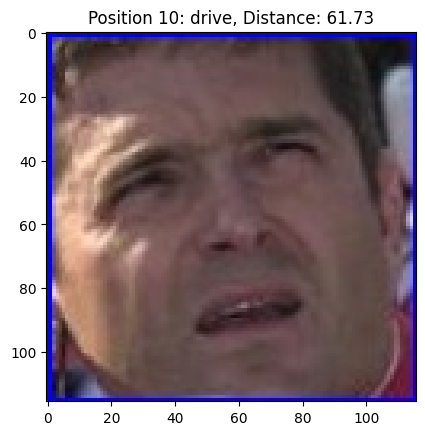

In [ ]:
# KDtree to Image 1

dist_image1_kd, ind_image1_kd = kd_tree.query(image1_features, k=10)

for x in range(0,10):
    title = 'Position ' + str(x+1) + ': ' + str(paths[ind_image1_kd[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distance: ' + str(round(dist_image1_kd[0][x], 2))

    temp = kimage.load_img(paths[ind_image1_kd[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(title)

## Applying BallTree to Image1

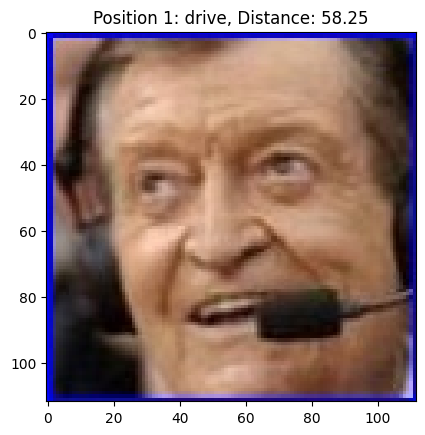

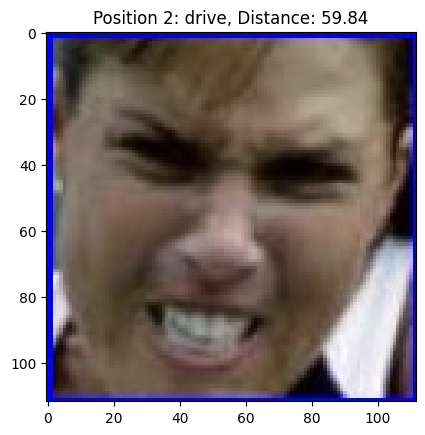

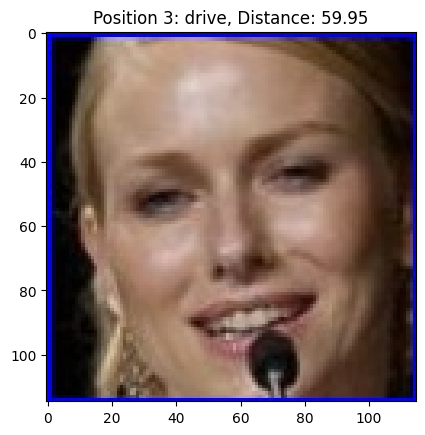

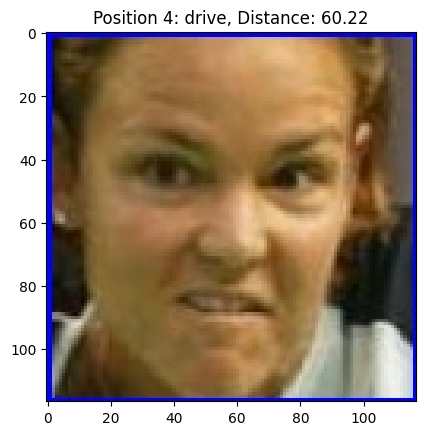

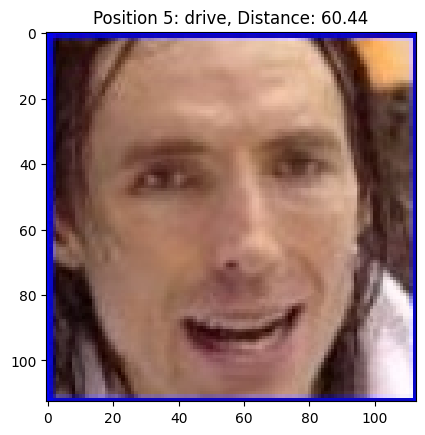

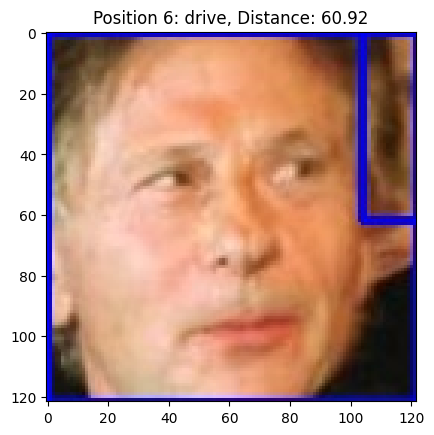

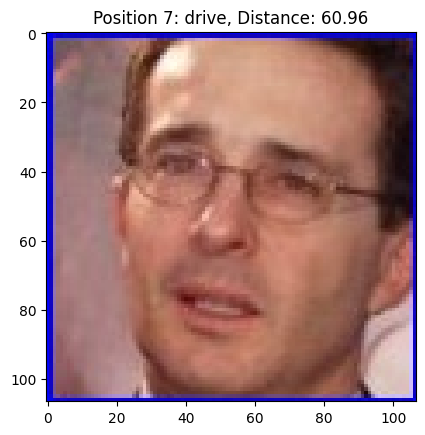

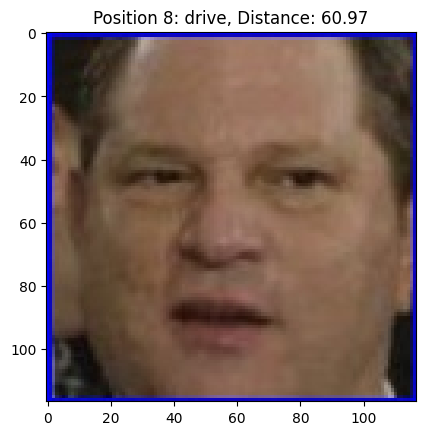

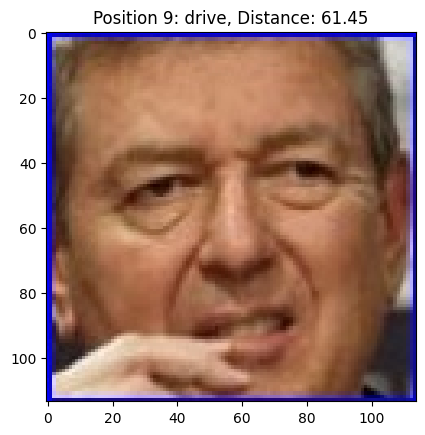

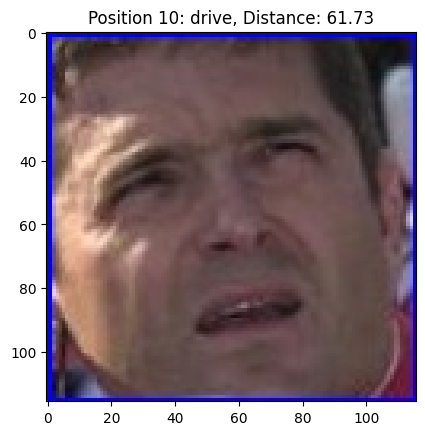

In [ ]:
# BallTree to Image1

dist_image1_ball, ind_image1_ball = ball_tree.query(image1_features, k=10)

for x in range(0,10):
    title = 'Position ' + str(x+1) + ': ' + str(paths[ind_image1_ball[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distance: ' + str(round(dist_image1_ball[0][x], 2))

    temp = kimage.load_img(paths[ind_image1_ball[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(title)

### Image 2

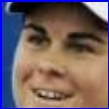

In [ ]:
# Path to the image
image_path = '/content/drive/MyDrive/output_folder/1005/0.jpg'

# Display the image
Image(filename=image_path)

## Applying KDtree to Image2

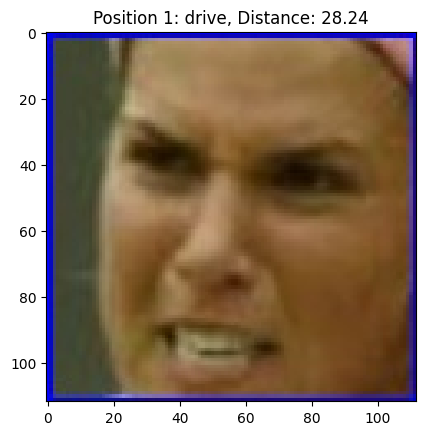

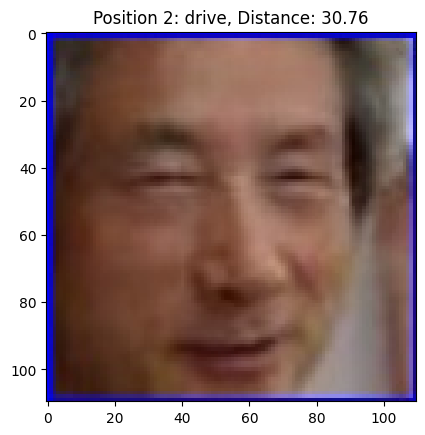

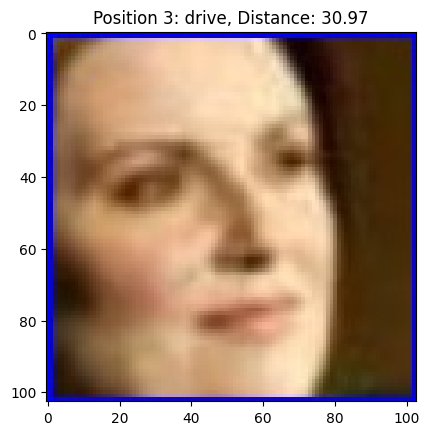

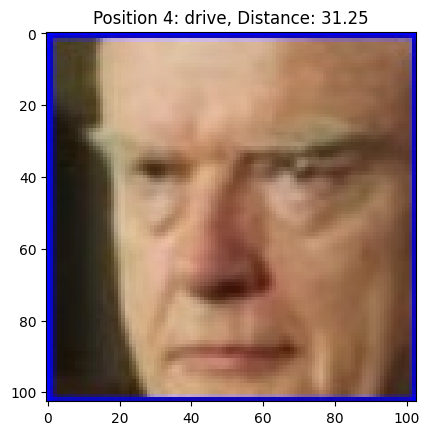

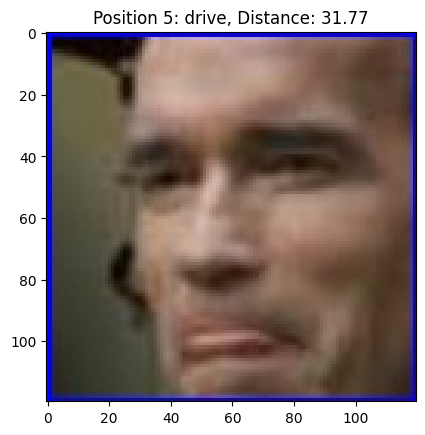

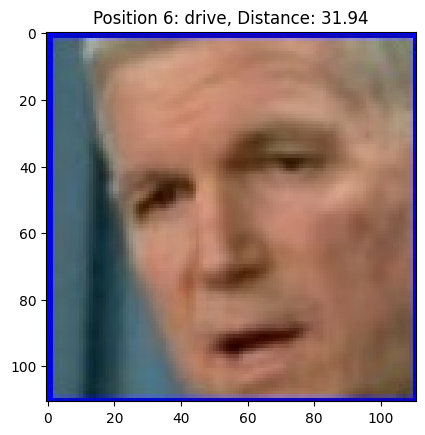

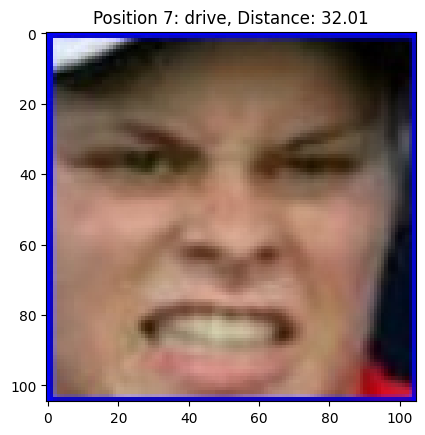

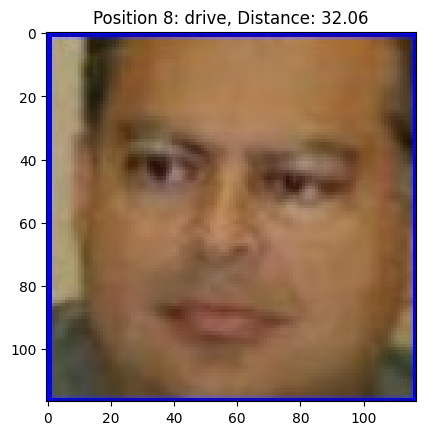

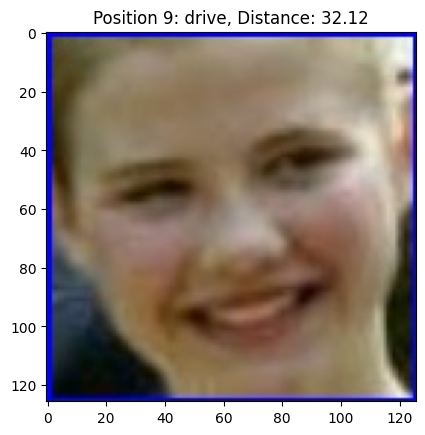

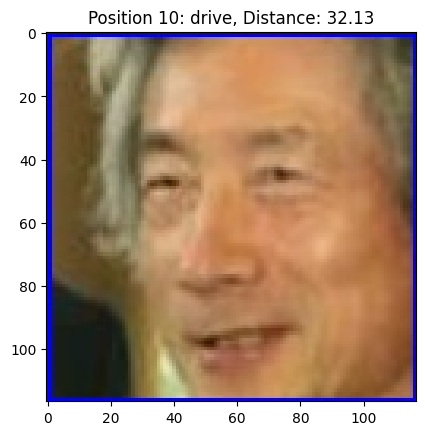

In [ ]:
# KDtree to Image 2

dist_image2_kd, ind_image2_kd = kd_tree.query(image2_features, k=10)

for x in range(0,10):
    title = 'Position ' + str(x+1) + ': ' + str(paths[ind_image2_kd[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distance: ' + str(round(dist_image2_kd[0][x], 2))

    temp = kimage.load_img(paths[ind_image2_kd[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(title)

## Applying BallTree to Image2

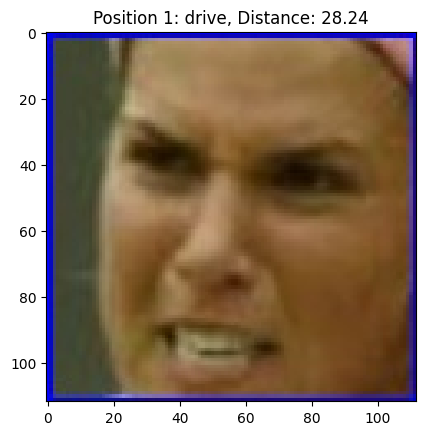

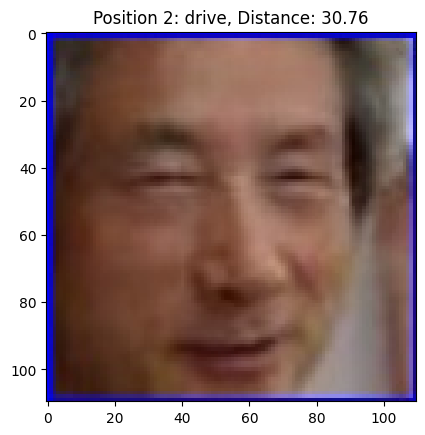

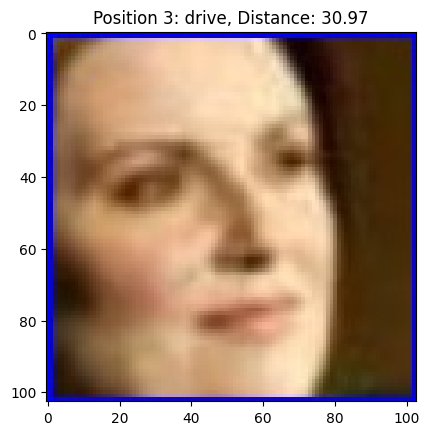

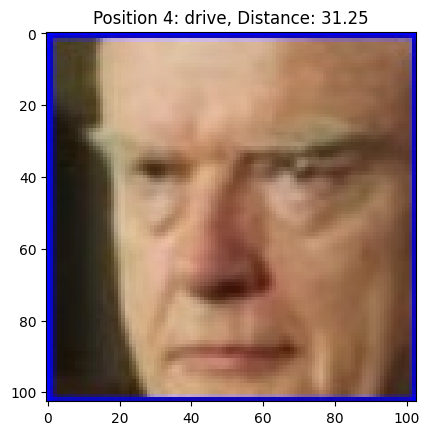

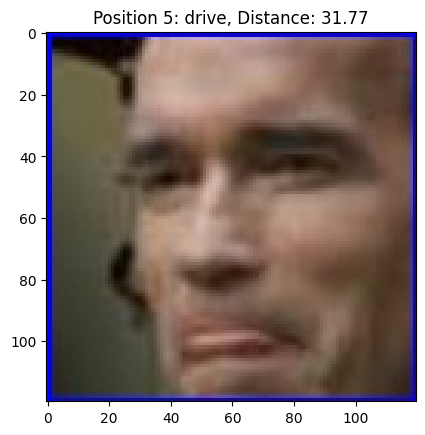

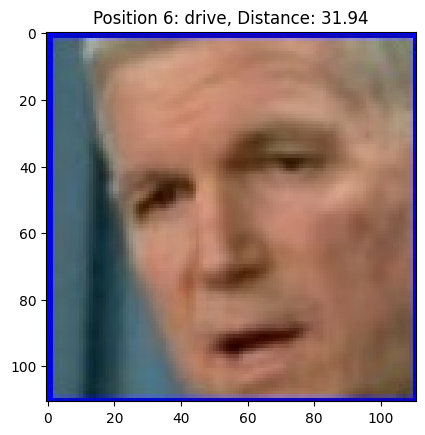

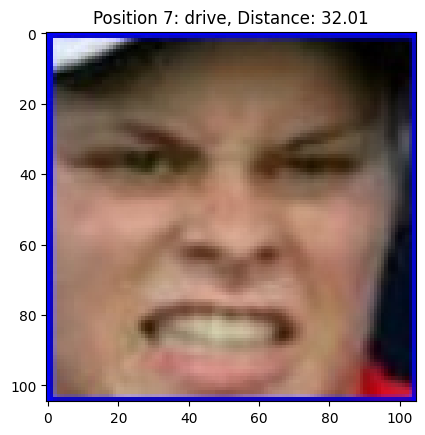

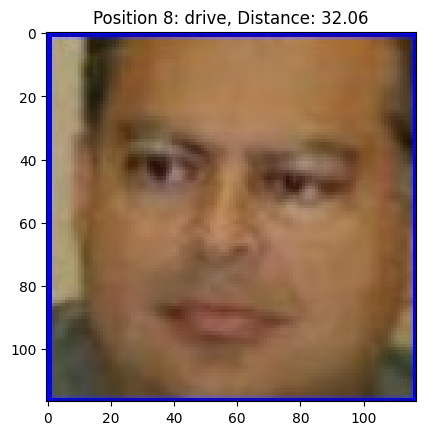

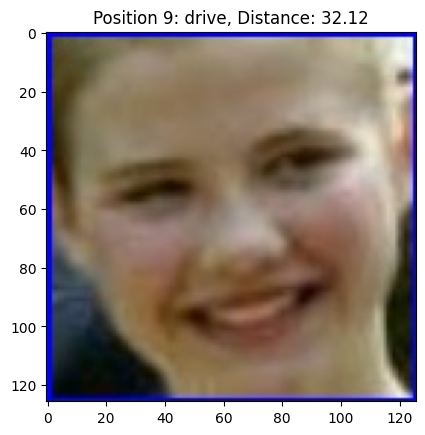

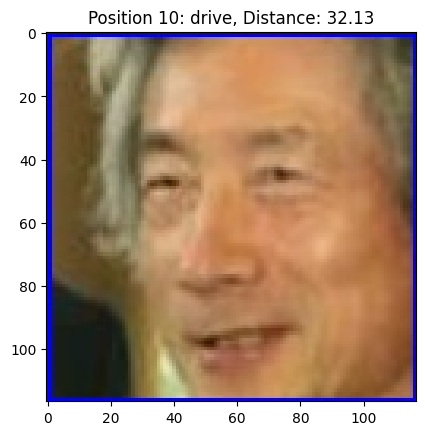

In [ ]:
# BallTree to Image 2

dist_image2_ball, ind_image2_ball = ball_tree.query(image2_features, k=10)

for x in range(0,10):
    title = 'Position ' + str(x+1) + ': ' + str(paths[ind_image2_ball[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distance: ' + str(round(dist_image2_ball[0][x], 2))

    temp = kimage.load_img(paths[ind_image2_ball[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(title)

### Image 3

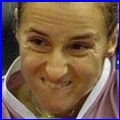

In [ ]:
# Path to the image
image_path = '/content/drive/MyDrive/output_folder/1003/1.jpg'

# Display the image
Image(filename=image_path)

## Applying KDtree to Image3

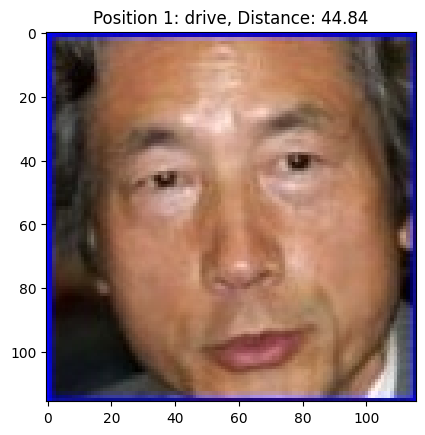

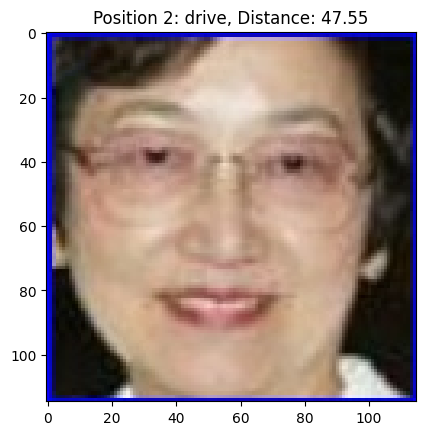

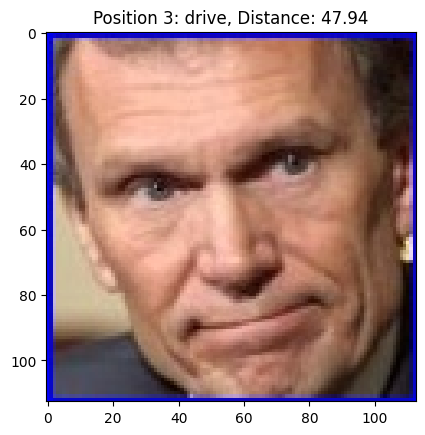

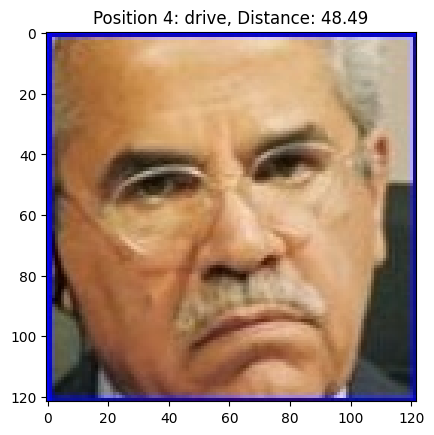

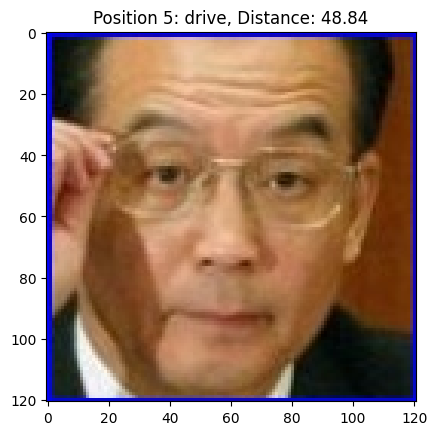

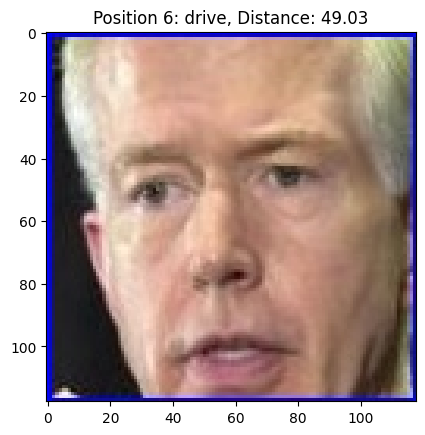

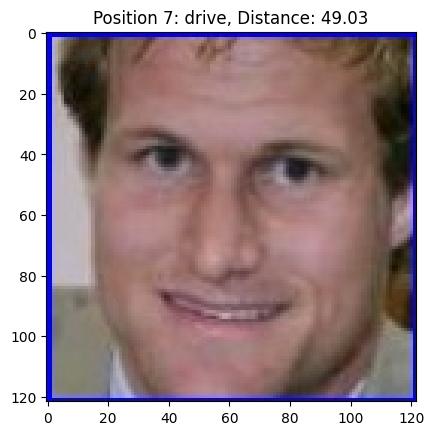

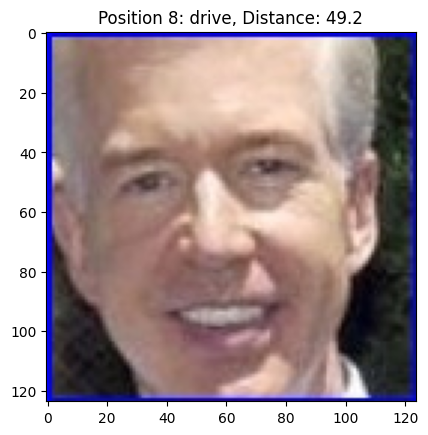

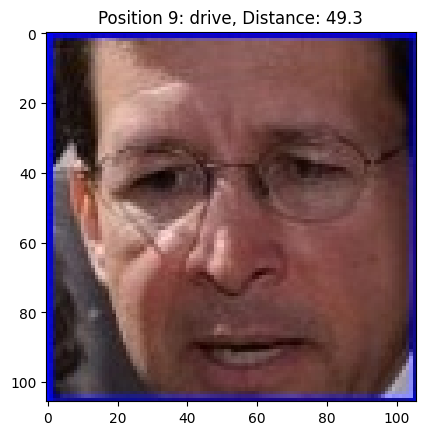

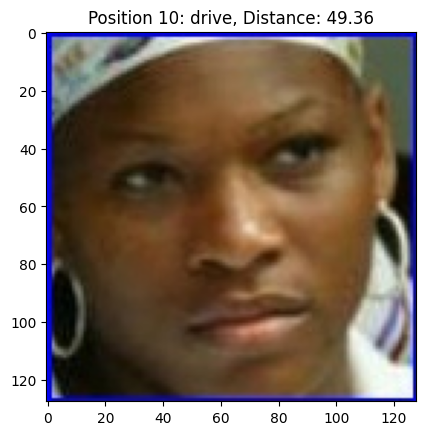

In [ ]:
# KDtree to Image 3

dist_image3_kd, ind_image3_kd = kd_tree.query(image3_features, k=10)

for x in range(0,10):
    title = 'Position ' + str(x+1) + ': ' + str(paths[ind_image3_kd[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distance: ' + str(round(dist_image3_kd[0][x], 2))

    temp = kimage.load_img(paths[ind_image3_kd[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(title)

## Applying BallTree to Image3

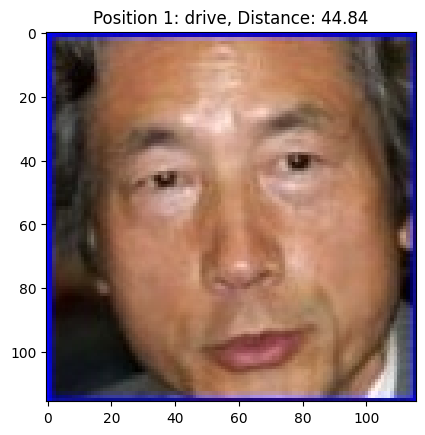

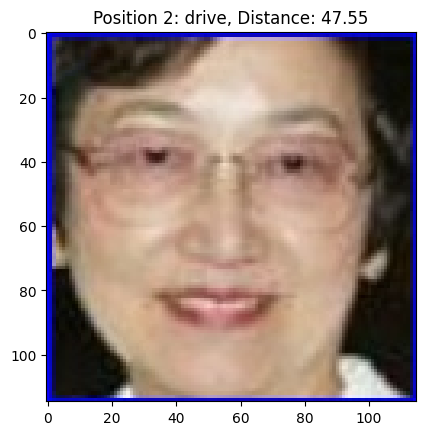

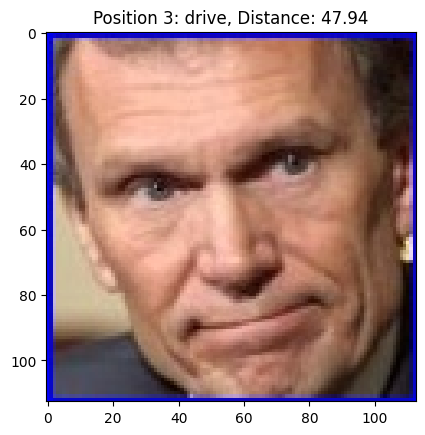

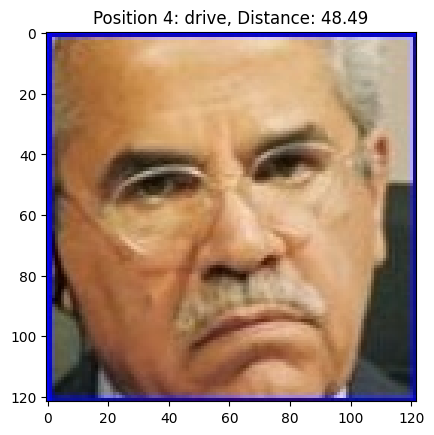

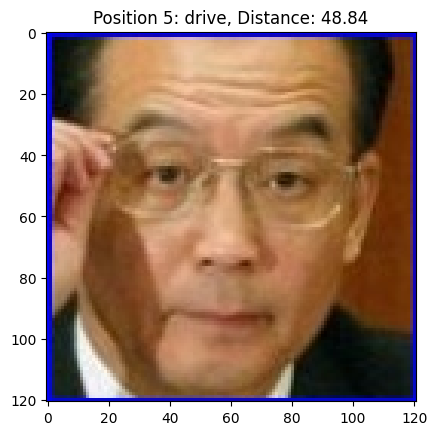

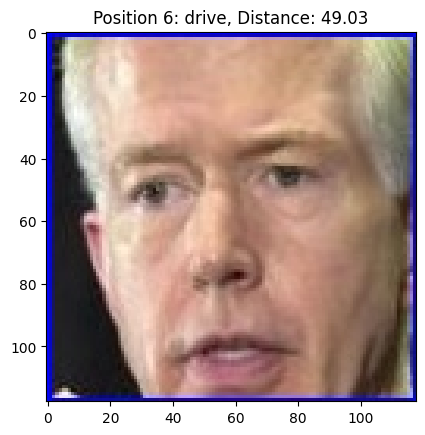

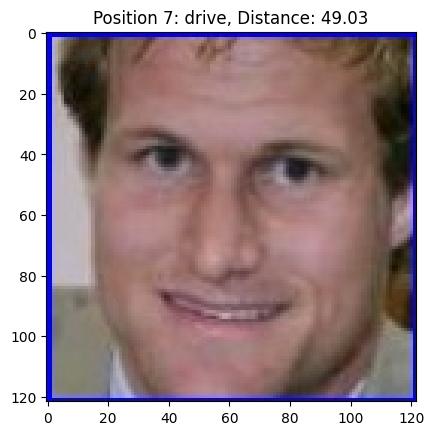

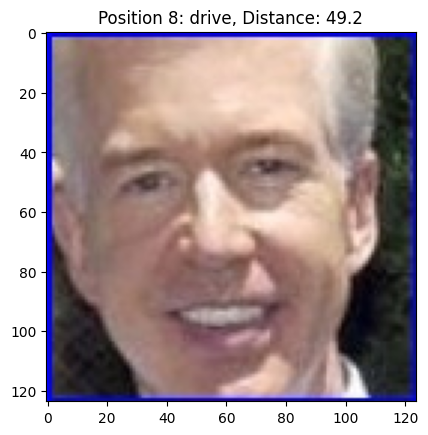

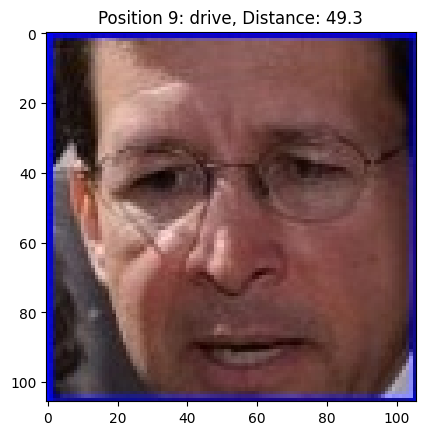

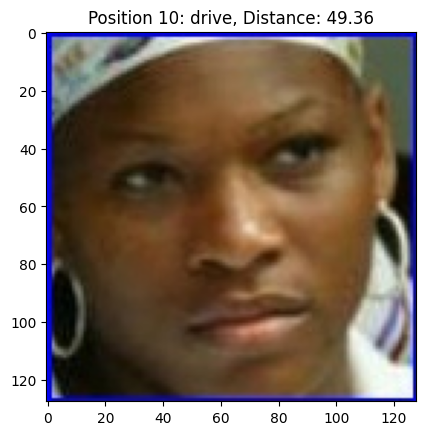

In [ ]:
# BallTree to Image 3

dist_image3_ball, ind_image3_ball = ball_tree.query(image3_features, k=10)

for x in range(0,10):
    title = 'Position ' + str(x+1) + ': ' + str(paths[ind_image3_ball[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distance: ' + str(round(dist_image3_ball[0][x], 2))

    temp = kimage.load_img(paths[ind_image3_ball[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(title)

### Image 4

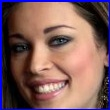

In [ ]:
# Path to the image
image_path = '/content/drive/MyDrive/output_folder/1027/1.jpg'

# Display the image
Image(filename=image_path)

### Applying KDtree to Image 4

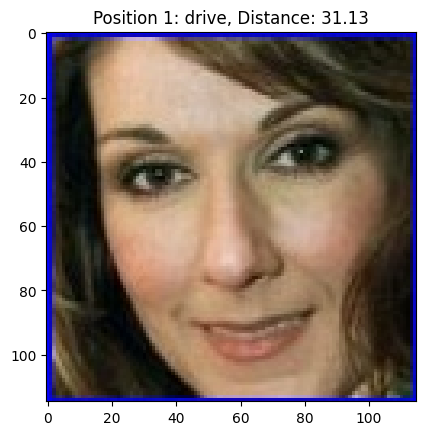

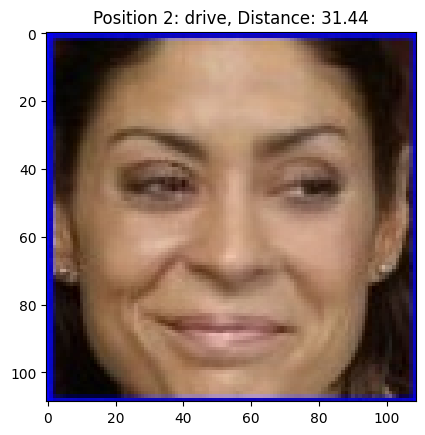

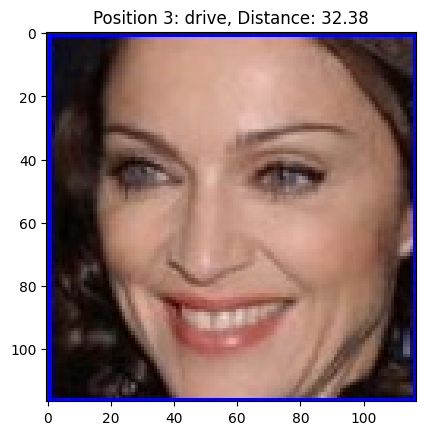

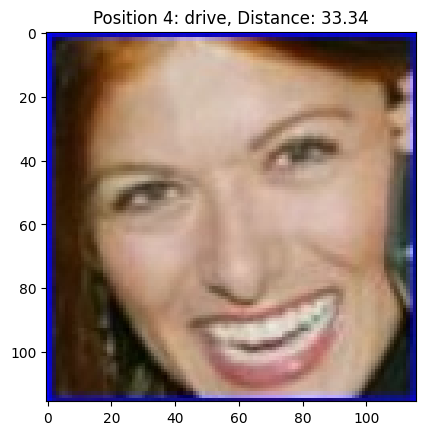

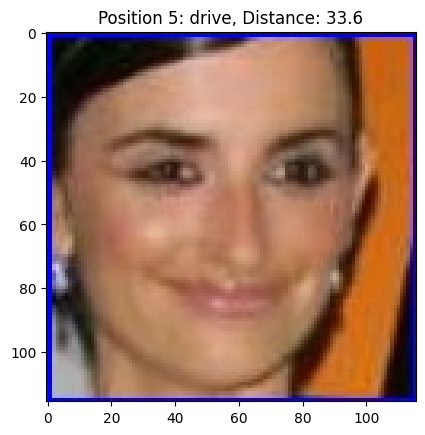

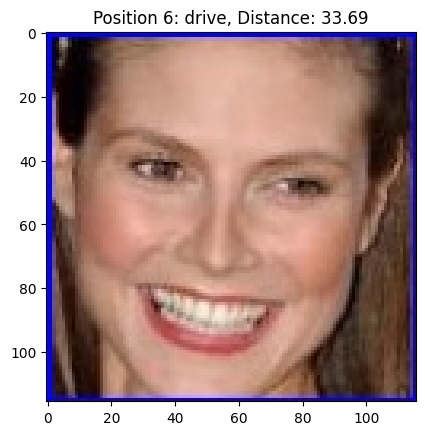

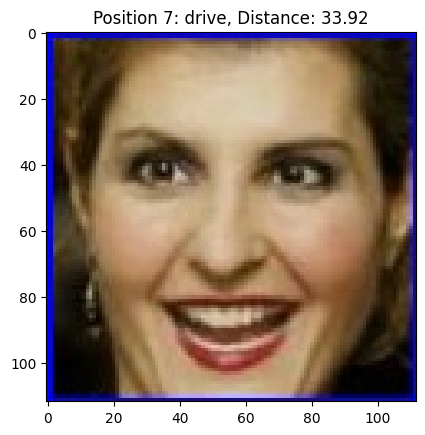

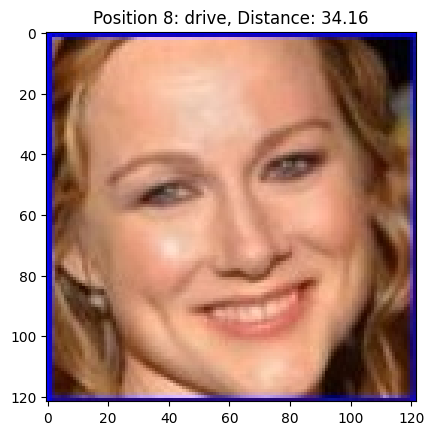

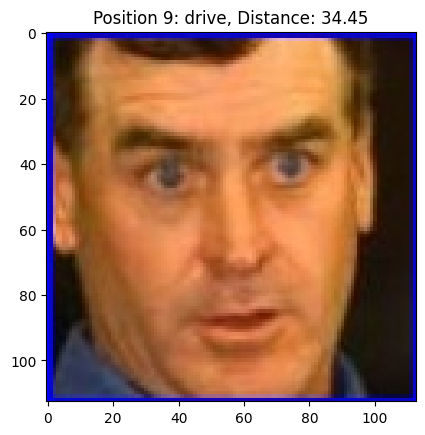

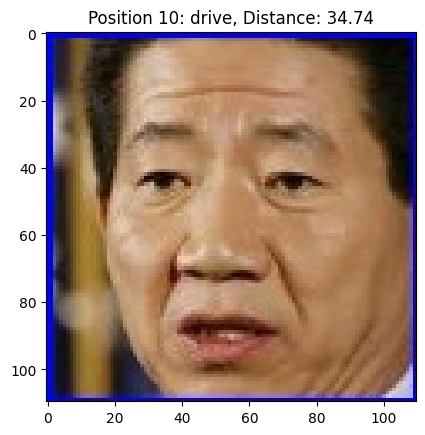

In [ ]:
# KDtree to Image 4

dist_image4_kd, ind_image4_kd = kd_tree.query(image4_features, k=10)

for x in range(0,10):
    title = 'Position ' + str(x+1) + ': ' + str(paths[ind_image4_kd[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distance: ' + str(round(dist_image4_kd[0][x], 2))

    temp = kimage.load_img(paths[ind_image4_kd[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(title)

### Applying BallTree to Image 4

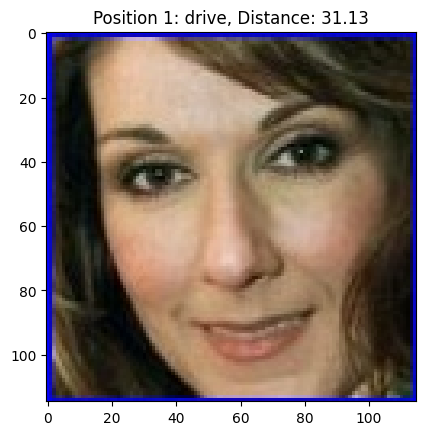

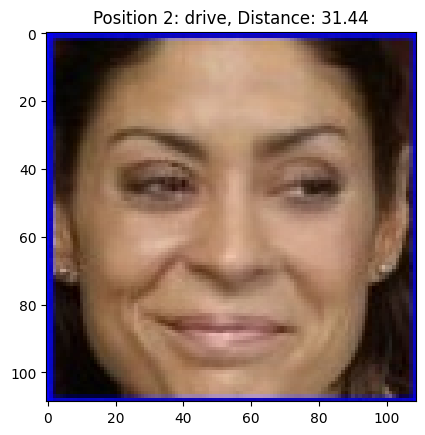

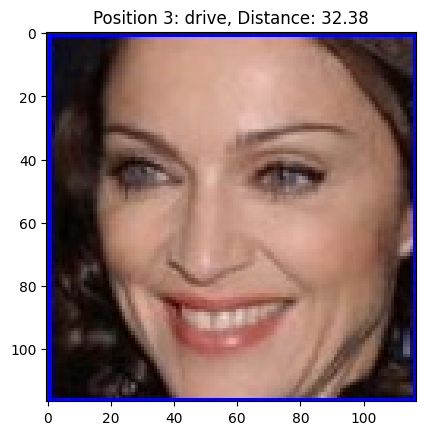

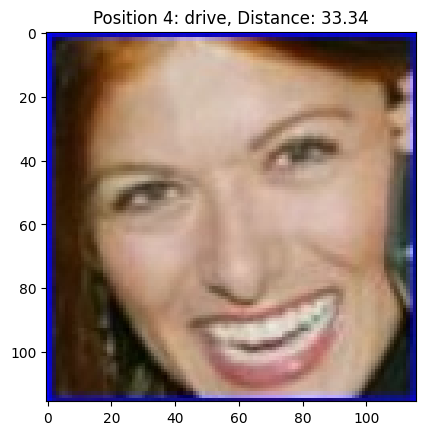

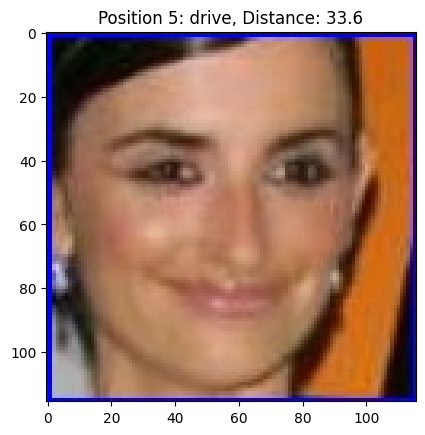

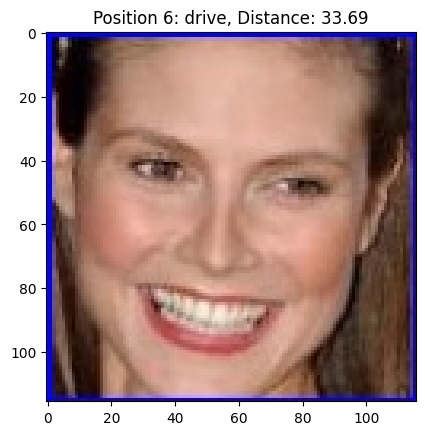

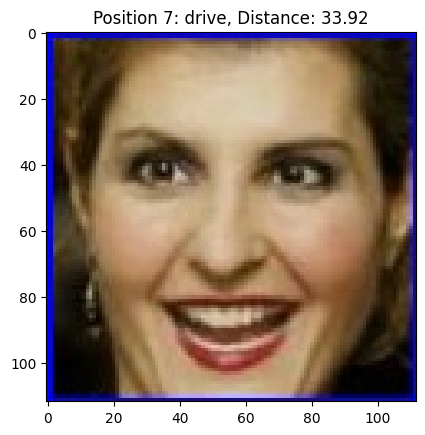

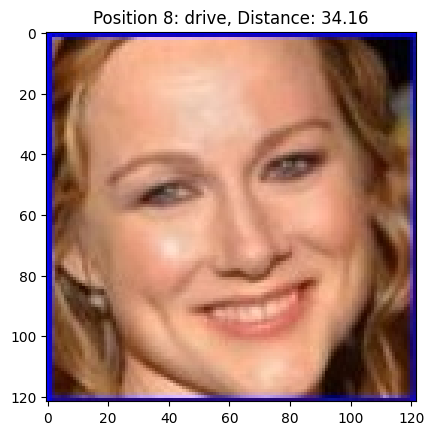

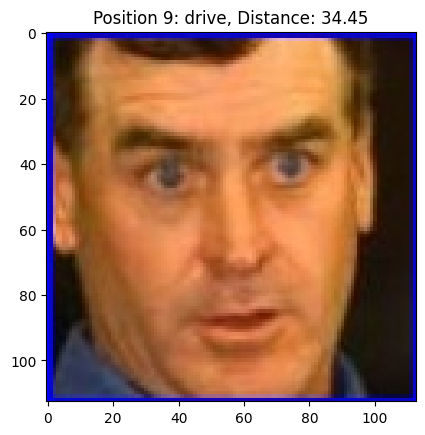

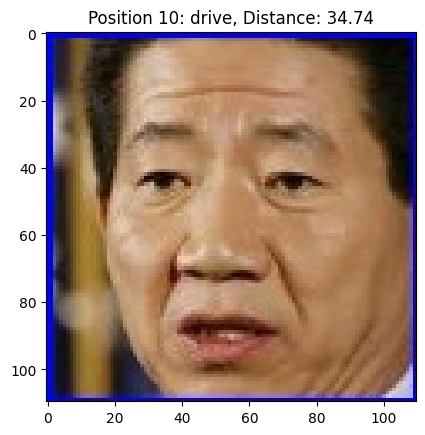

In [ ]:
# BallTree to Image 4

dist_image4_ball, ind_image4_ball = ball_tree.query(image4_features, k=10)

for x in range(0,10):
    title = 'Position ' + str(x+1) + ': ' + str(paths[ind_image4_ball[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distance: ' + str(round(dist_image4_ball[0][x], 2))

    temp = kimage.load_img(paths[ind_image4_ball[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(title)

### Image 5

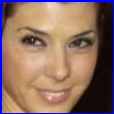

In [ ]:
# Path to the image
image_path = '/content/drive/MyDrive/output_folder/1033/0.jpg'

# Display the image
Image(filename=image_path)

### Applying KDtree to Image 5

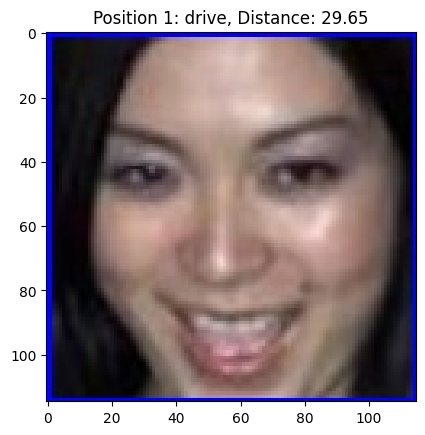

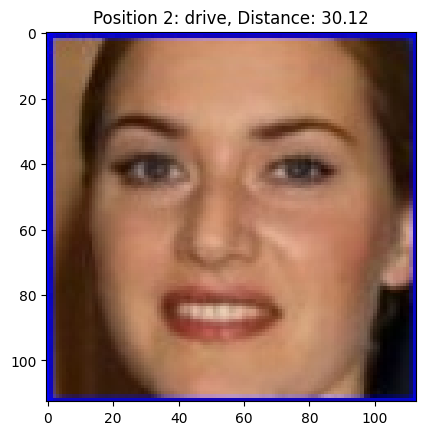

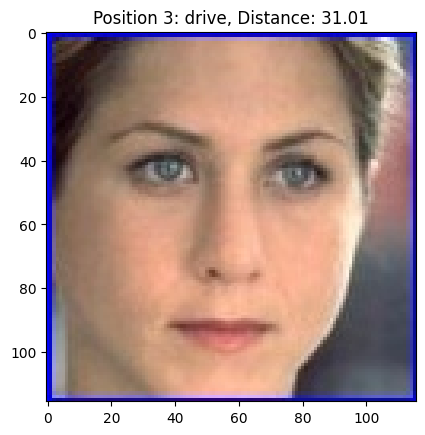

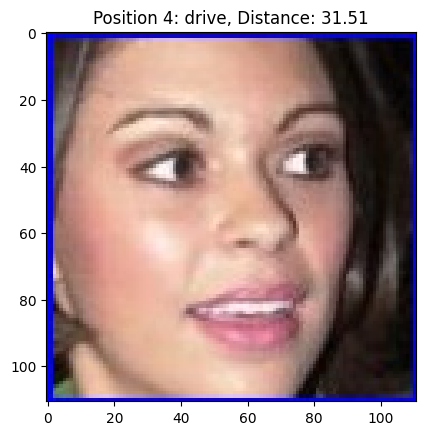

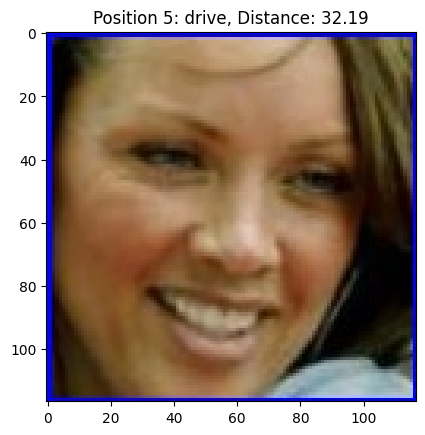

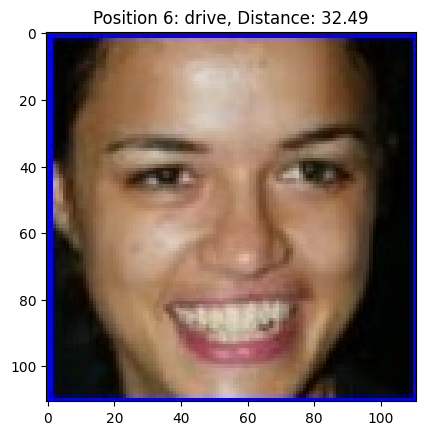

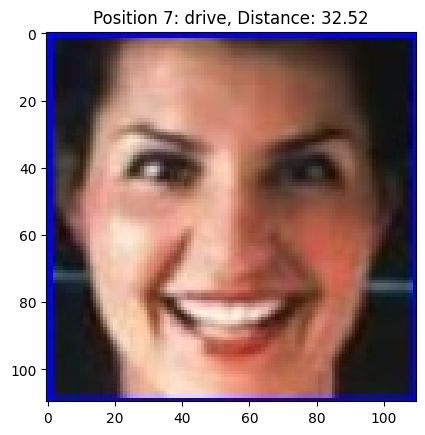

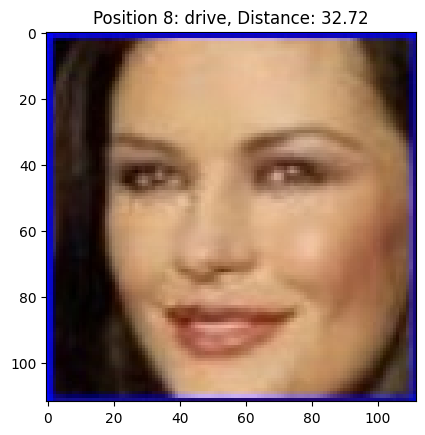

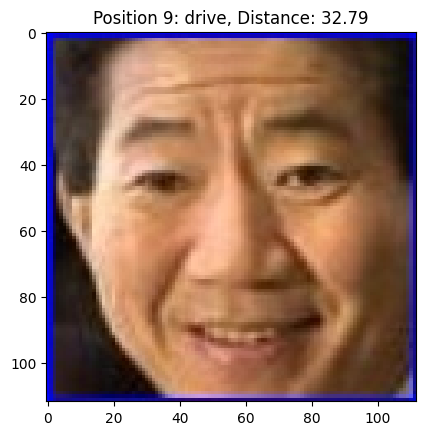

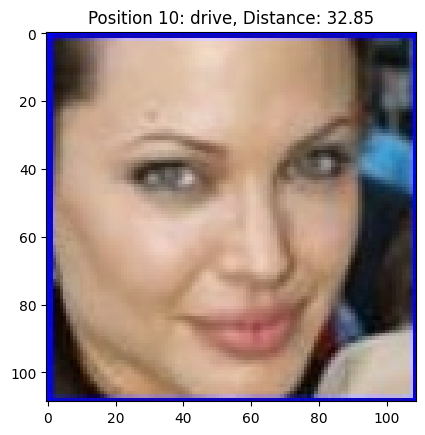

In [ ]:
# KDtree to Image 5

dist_image5_kd, ind_image5_kd = kd_tree.query(image5_features, k=10)

for x in range(0,10):
    title = 'Position ' + str(x+1) + ': ' + str(paths[ind_image5_kd[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distance: ' + str(round(dist_image5_kd[0][x], 2))

    temp = kimage.load_img(paths[ind_image5_kd[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(title)

### Applying BallTree to Image 5

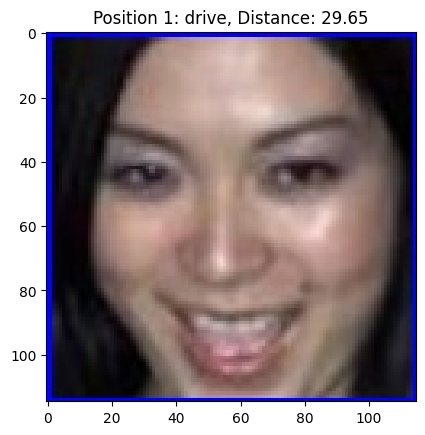

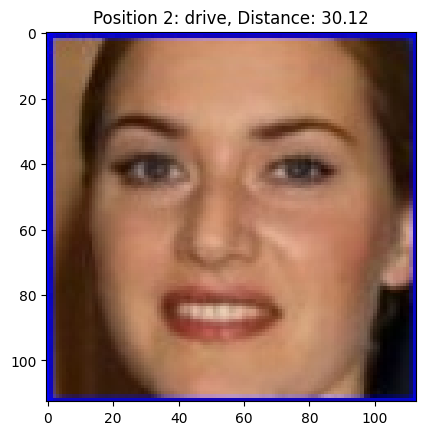

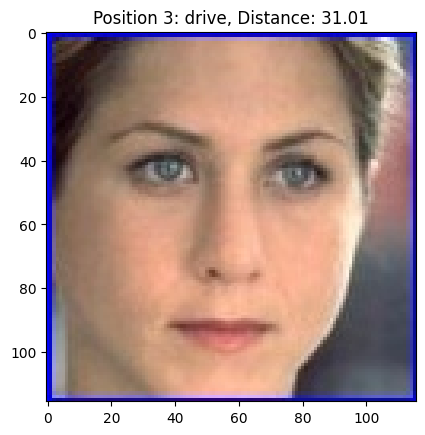

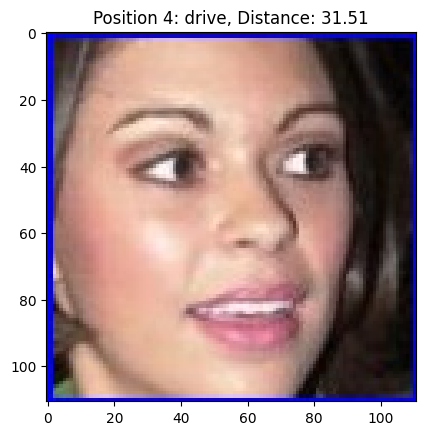

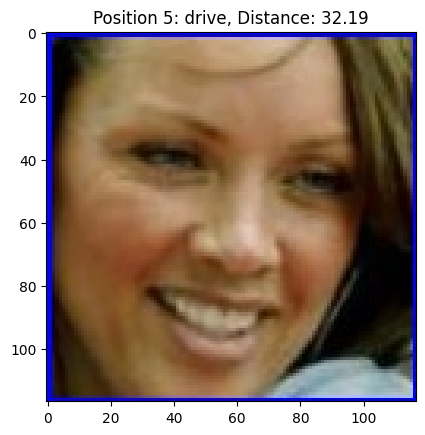

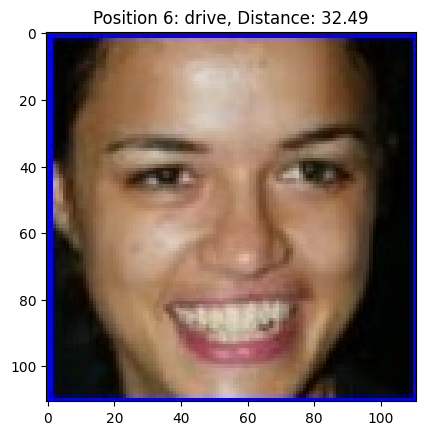

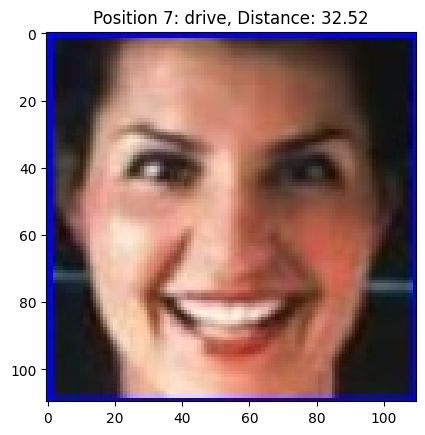

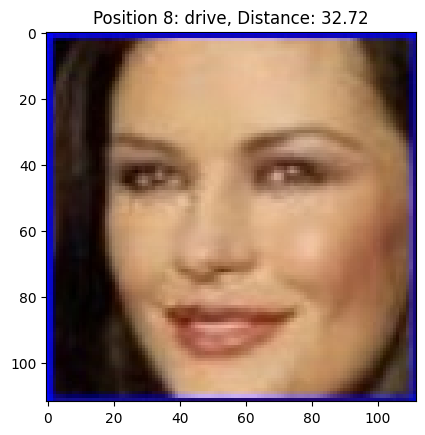

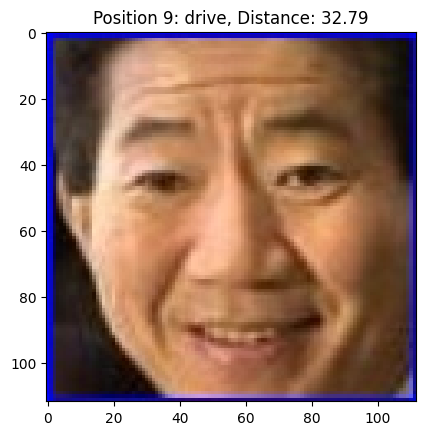

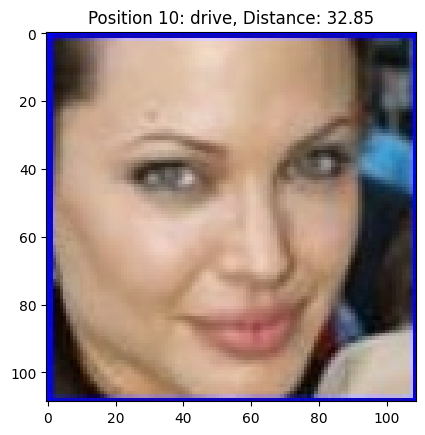

In [ ]:
# BallTree to Image 5

dist_image5_ball, ind_image5_ball = ball_tree.query(image5_features, k=10)

for x in range(0,10):
    title = 'Position ' + str(x+1) + ': ' + str(paths[ind_image5_ball[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distance: ' + str(round(dist_image5_ball[0][x], 2))

    temp = kimage.load_img(paths[ind_image5_ball[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(title)

### Image 6

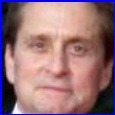

In [ ]:
# Path to the image
image_path = '/content/drive/MyDrive/output_folder/1097/1.jpg'

# Display the image
Image(filename=image_path)

### Applying KDtree to Image 6

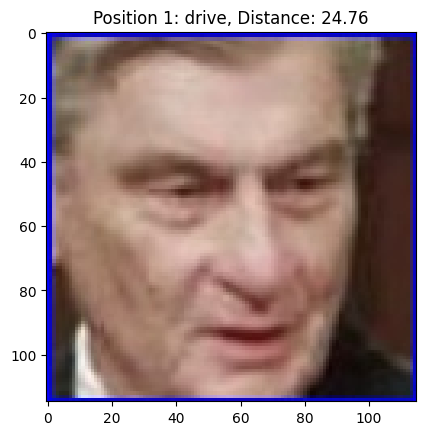

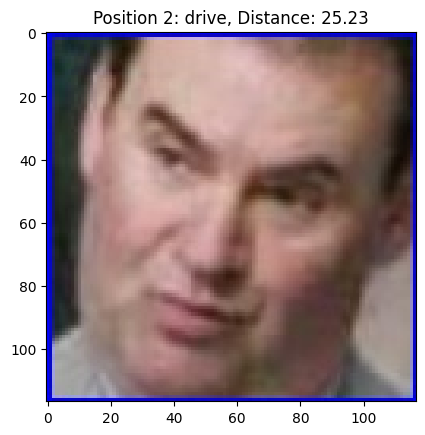

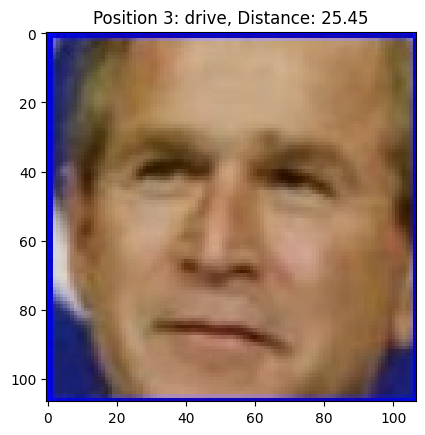

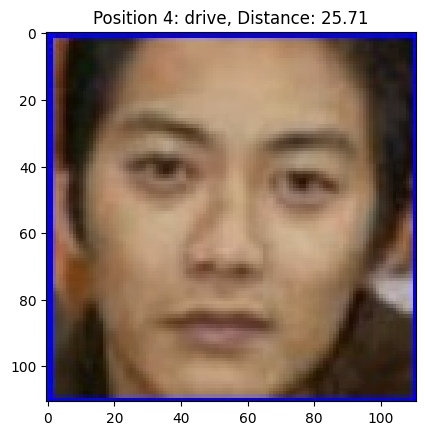

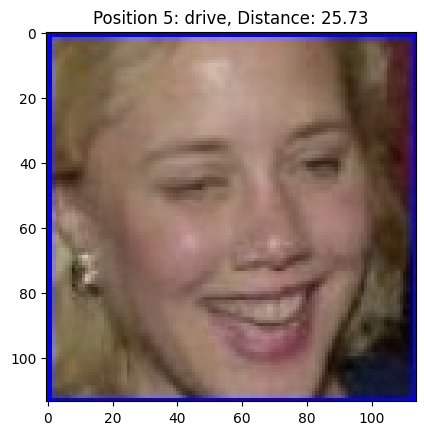

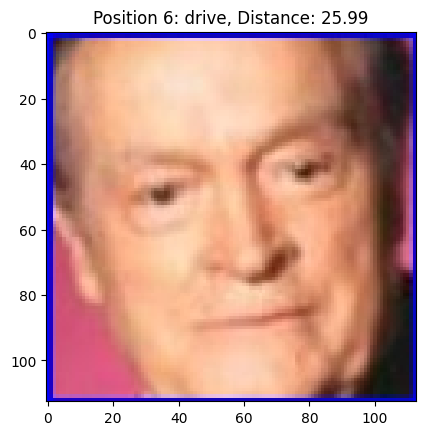

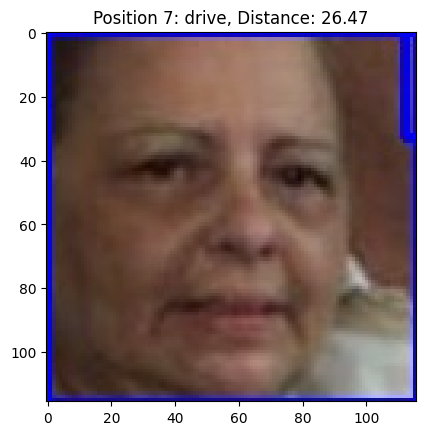

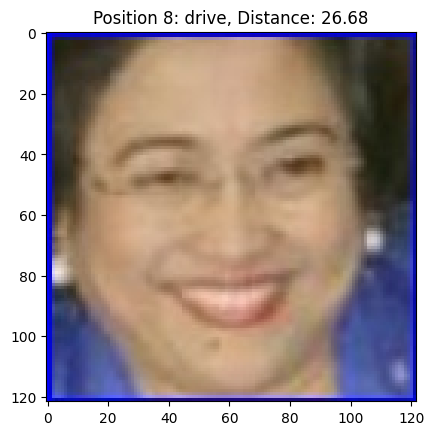

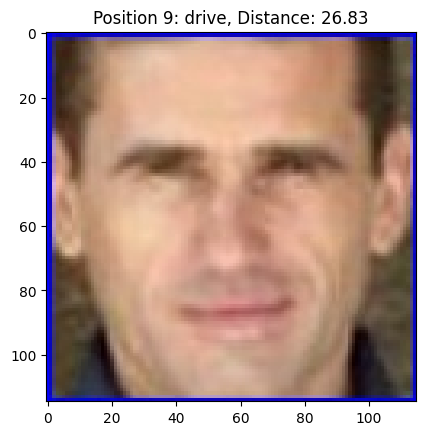

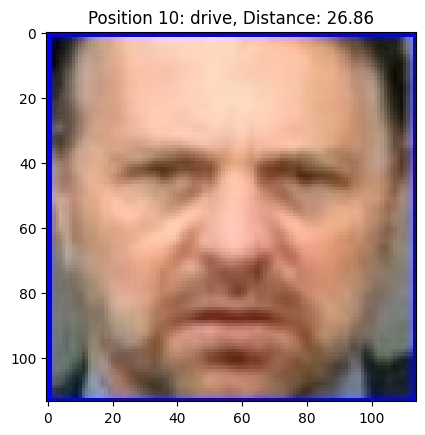

In [ ]:
# KDtree to Image 6

dist_image6_kd, ind_image6_kd = kd_tree.query(image6_features, k=10)

for x in range(0,10):
    title = 'Position ' + str(x+1) + ': ' + str(paths[ind_image6_kd[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distance: ' + str(round(dist_image6_kd[0][x], 2))

    temp = kimage.load_img(paths[ind_image6_kd[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(title)

### Applying BallTree to Image 6

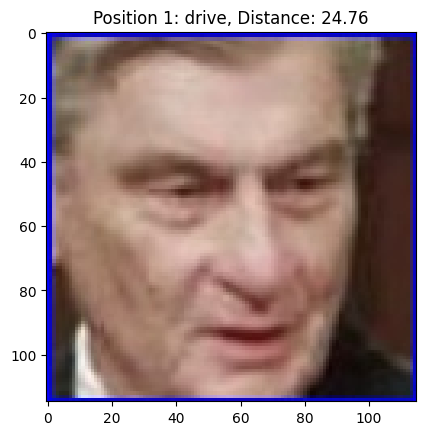

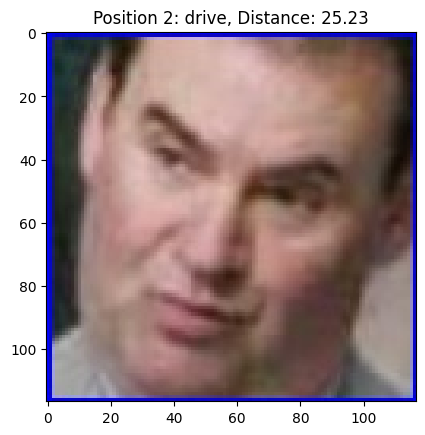

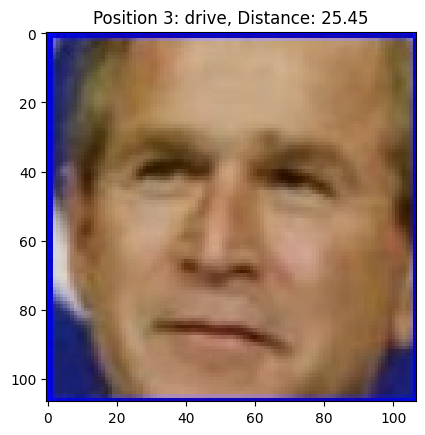

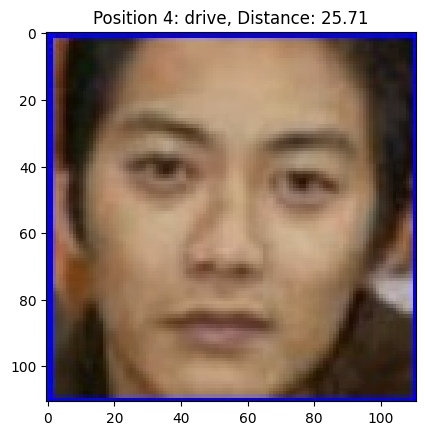

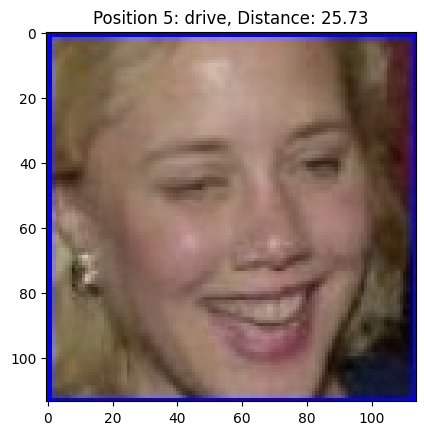

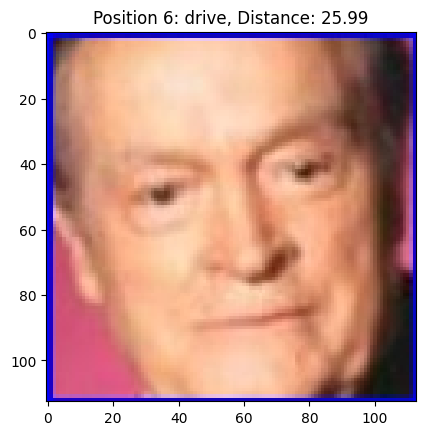

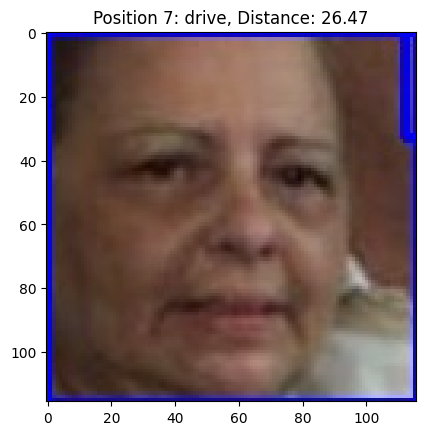

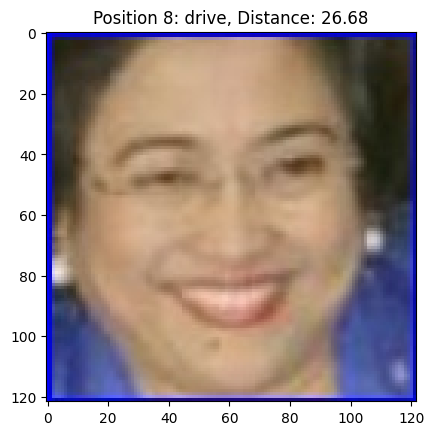

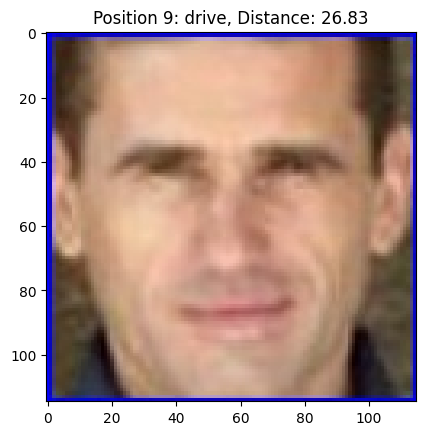

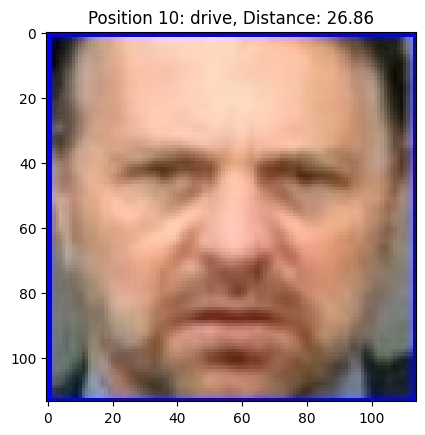

In [ ]:
# BallTree to Image 6

dist_image6_ball, ind_image6_ball = ball_tree.query(image6_features, k=10)

for x in range(0,10):
    title = 'Position ' + str(x+1) + ': ' + str(paths[ind_image6_ball[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distance: ' + str(round(dist_image6_ball[0][x], 2))

    temp = kimage.load_img(paths[ind_image6_ball[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(title)